In [1]:
# imports
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from tqdm import tqdm

In [12]:
# hyperparameters
batch_size = 128
num_workers = 4
epochs = 50
n = 2
r = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
norm_type = "torch_bn"
print("Running on device =", device)

Running on device = cuda


In [13]:
def layer_normalization(dim, norm_type):
    if norm_type == "torch_bn":
        return nn.BatchNorm2d(dim)
    

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, norm_type="torch_bn"):
        super(ResidualBlock, self).__init__()
        """
        Args:
            channels: Int: Number of Input channels to 1st convolutional layer
            kernel_size: integer, Symmetric Conv Window = (kernel_size, kernel_size)
            filters: python list of integers, defining the number of filters in the CONV layers of the main path
            stride: Int
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.norm_type = norm_type
        self.downsample = downsample
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv1 = nn.Conv2d(
            self.in_channels, self.out_channels, kernel_size=self.kernel_size, stride=stride, 
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            self.out_channels, self.out_channels, kernel_size=self.kernel_size, stride=1, 
            padding=1, bias=False
        )
        self.relu = nn.ReLU()
        self.norm1 = layer_normalization(out_channels, norm_type)
        self.norm2 = layer_normalization(out_channels, norm_type)
        
    def forward(self, x):
        x_residual = x
        
        if self.downsample is not None:
            x_residual = self.downsample(x)
            
        out = self.norm1(self.conv1(x))
        out = self.relu(out)
        out = self.norm2(self.conv2(out))
        
        out += x_residual
        out = self.relu(out)
        
        return out
        
class ResNet(nn.Module):
    def __init__(self, n_channels = [16, 32, 64], n_layers = [2, 2, 2], n_classes = 10, norm_type = "torch_bn"):
        super(ResNet, self).__init__()
        """
        Input:
        channels: List of channels in residual layers
        n_layers: list of number of residual blocks to be added in the network
        n_classes: number of classes
        norm_type: type of normalization to be used in the network
        """
        
        self.n_channels = n_channels
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.norm_type = norm_type
        
        self.conv = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.layer_norm = layer_normalization(n_channels[0], norm_type)
        self.relu = nn.ReLU()
        self.in_channels = n_channels[0]        
        self.out_channels = 0
                 
        layers = dict()
        for c in range(len(n_channels)):
            layer = list()
            self.out_channels = n_channels[c]
            n = n_layers[c]
            
            for l in range(n):
                downsample = None                
                if self.in_channels != self.out_channels:
                    """CHECK KERNEL SIZE HERE"""
                    downsample = nn.Sequential(
                        nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, 
                                  stride=2, padding=1, bias=False), 
                        layer_normalization(self.out_channels, norm_type)
                    )
                if c > 0 and l == 0:
                    stride = 2
                else:
                    stride = 1
                layer.append(ResidualBlock(self.in_channels, self.out_channels, stride = stride, downsample = downsample))
                if l == 0:
                    self.in_channels = self.out_channels       
            layers[c+1] = layer
            
        self.layer1 = nn.Sequential(*layers[1])
        self.layer2 = nn.Sequential(*layers[2])
        self.layer3 = nn.Sequential(*layers[3])
        self.avg_pool = nn.AvgPool2d(kernel_size = 8)
        self.fc = nn.Linear(64, n_classes)
        
    def forward(self, x):
#         print("Input Shape:", x.shape)
        # input convolution
        x = self.layer_norm(self.conv(x))
        x = self.relu(x)
#         print("first conv:", x.shape)
        # residual layers
        x = self.layer1(x)
#         print("layer 1 done:", x.shape)
        x = self.layer2(x)
#         print("layer 2 done:", x.shape)
        x = self.layer3(x)
#         print("layer 3 done:", x.shape)
        
        # average pool
        x = self.avg_pool(x)
        
        # flatten and fc out
        x = x.view(-1, 64)
        x = self.fc(x)
        
        return x
        


Train Size = 40000, Val Size = 10000, Test Size = 10000
Model to device:  cuda


---------------------------- MODEL TRAINING BEGINS ----------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.52it/s]


Accuracy 0.4324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.02it/s]


Accuracy 0.5165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.51it/s]


Accuracy 0.5831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.74it/s]


Accuracy 0.7138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.17it/s]


Accuracy 0.7459


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.26it/s]


Accuracy 0.7324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.69it/s]


Accuracy 0.7775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.18it/s]


Accuracy 0.7857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.77it/s]


Accuracy 0.8066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.44it/s]


Accuracy 0.7408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.98it/s]


Accuracy 0.7849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.56it/s]


Accuracy 0.7976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.15it/s]


Accuracy 0.7754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.83it/s]


Accuracy 0.8131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.31it/s]


Accuracy 0.8018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.81it/s]


Accuracy 0.7866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.69it/s]


Accuracy 0.7928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.78it/s]


Accuracy 0.8294


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.83it/s]


Accuracy 0.8125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.52it/s]


Accuracy 0.7884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.96it/s]


Accuracy 0.8212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.65it/s]


Accuracy 0.824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.07it/s]


Accuracy 0.8403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.01it/s]


Accuracy 0.8376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.96it/s]


Accuracy 0.8347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.27it/s]


Accuracy 0.815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 89.09it/s]


Accuracy 0.8527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.65it/s]


Accuracy 0.8382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.88it/s]


Accuracy 0.8324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.00it/s]


Accuracy 0.8035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.99it/s]


Accuracy 0.8227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.92it/s]


Accuracy 0.8418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.72it/s]


Accuracy 0.8455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.10it/s]


Accuracy 0.8557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.53it/s]


Accuracy 0.8479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.37it/s]


Accuracy 0.8474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.61it/s]


Accuracy 0.8449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.59it/s]


Accuracy 0.8539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.92it/s]


Accuracy 0.8462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 93.26it/s]


Accuracy 0.8477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.15it/s]


Accuracy 0.8516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 92.36it/s]


Accuracy 0.8508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 96.64it/s]


Accuracy 0.8563


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.14it/s]


Accuracy 0.8597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.19it/s]


Accuracy 0.8405


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.75it/s]


Accuracy 0.8701


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.15it/s]


Accuracy 0.8596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.79it/s]


Accuracy 0.8643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.26it/s]


Accuracy 0.8597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 94.98it/s]


Accuracy 0.846


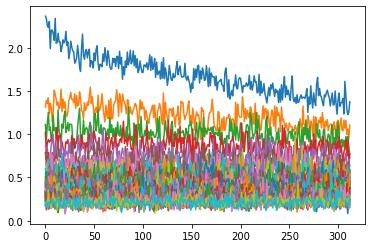

In [15]:
def train():
    train_transforms = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    
    dataset = torchvision.datasets.CIFAR10(root=os.path.join("..","data"), train=True, transform=train_transforms)
    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers
    )
    
    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])
    
    test_dataset = torchvision.datasets.CIFAR10(root=os.path.join("..","data"), train=False, transform=test_transforms)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers
    )
    print("Train Size = {}, Val Size = {}, Test Size = {}".format(len(train_dataset), len(val_dataset), len(test_dataset)))
    net = ResNet(norm_type = norm_type)
    net = net.to(device)
#     print(net)
    print("Model to device: ", device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
    
    print("\n\n---------------------------- MODEL TRAINING BEGINS ----------------------------")
    for epoch in range(epochs):
        loss_val = []
        for idx, batch in enumerate(tqdm(train_loader)):
            
            optimizer.zero_grad()
            
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            preds = net(images)
            
            loss = criterion(preds, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_val.append(loss.item())
        plt.plot(loss_val)    
        scheduler.step()
        
        net.eval()
        actuals = []
        preds = []
        for i, sample in enumerate(tqdm(test_loader)):
            images, labels = sample
            images = images.to(device)
            labels = labels.to(device)
            actuals.extend(labels.squeeze().tolist())
            pred = net(images)
            preds.extend(torch.argmax(pred, dim=1).squeeze().tolist())

        print("Accuracy", accuracy_score(actuals, preds))
        net.train()
    
train()

In [16]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
date_time = now.strftime("%Y%m%d_%H%M")
print(date_time)

20230301_2244


In [19]:
result = ["TORCH_BN", "TEST ACCU = 89%", "MICRO F1 = 0.89", "MACRO F1 = 0.95"]
with open(os.path.join("./", "test_perormance.txt"), "w") as res:
    for r in result:
        res.writelines(r)
        res.writelines("\n")

In [21]:
import os
os.path.isfile("./" + "test_perormance.txt")

True

In [1]:
import matplotlib.pyplot as plt
import json

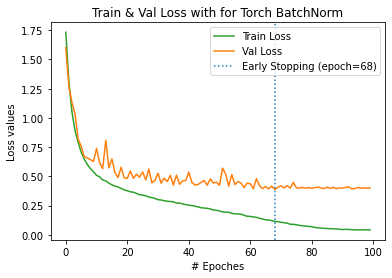

In [41]:
with open("../results/torch_bn_aug/loss_tracker_torch_bn_20230306_1221.json", "r+") as file:
    loss_dict = json.load(file)
    
plt.plot(list(range(len(loss_dict['train']))), loss_dict['train'], c="tab:green", label="Train Loss")
plt.plot(list(range(len(loss_dict['val']))), loss_dict['val'], c="tab:orange", label="Val Loss")
plt.axvline(x = np.argmin(loss_dict['val']), linestyle="dotted", label = f"Early Stopping (epoch={np.argmin(loss_dict['val'])})")
plt.title("Train & Val Loss with for Torch BatchNorm")
plt.xlabel("# Epoches")
plt.ylabel("Loss values")
plt.legend()

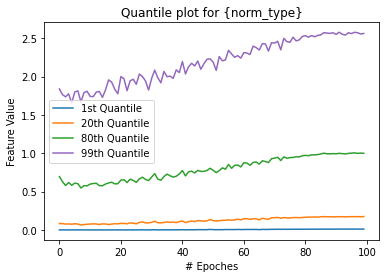

In [6]:
with open("../results/bn/ft_quantile_tracker_bn_20230309_1640.json", "r+") as file:
    quantile_dict = json.load(file)
norm_type = "Batch Normalization"
plt.plot(list(range(100)), quantile_dict['1'], c="tab:blue", label="1st Quantile")
plt.plot(list(range(100)), quantile_dict['20'], c="tab:orange", label="20th Quantile")
plt.plot(list(range(100)), quantile_dict['80'], c="tab:green", label="80th Quantile")
plt.plot(list(range(100)), quantile_dict['99'], c="tab:purple", label="99th Quantile")
plt.title("Quantile plot for {norm_type}")
plt.xlabel("# Epoches")
plt.ylabel("Feature Value")
plt.legend()

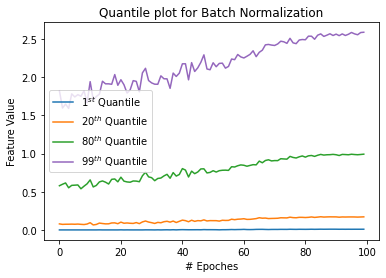

In [10]:
with open("../results/torch_bn/ft_quantile_tracker_torch_bn_20230309_1621.json", "r+") as file:
    quantile_dict = json.load(file)
norm_type = "Batch Normalization"
plt.plot(list(range(100)), quantile_dict['1'], c="tab:blue", label="1$^{st}$ Quantile")
plt.plot(list(range(100)), quantile_dict['20'], c="tab:orange", label="20$^{th}$ Quantile")
plt.plot(list(range(100)), quantile_dict['80'], c="tab:green", label="80$^{th}$ Quantile")
plt.plot(list(range(100)), quantile_dict['99'], c="tab:purple", label="99$^{th}$ Quantile")
plt.title(f"Quantile plot for {norm_type}")
plt.xlabel("# Epoches")
plt.ylabel("Feature Value")
plt.legend()

In [11]:
from glob import glob

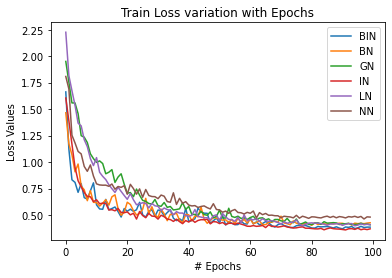

In [18]:
fig = plt.figure()
json_list = glob("../results/**/loss_tracker*.json")
json_list.sort()
for file in json_list:
    with open(file, "r+") as f:
        json_dict = json.load(f)
    
    norm_type = file.split("/")[-2]
    if norm_type != "torch_bn":
        plt.plot(list(range(100)), json_dict['val'], label=norm_type.upper())
    
plt.title(f"Train Loss variation with Epochs")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()